In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/train.csv")
df_train = pd.DataFrame()
df_train['Date'] = pd.to_datetime(df['dt'], format="%d.%m.%Y")
df_train['Price'] = df['Цена на арматуру']
df = pd.read_csv("data/test.csv")
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(df['dt'], format="%Y.%m.%d")
df_test['Price'] = df['Цена на арматуру']
df = pd.concat((df_train, df_test)).reset_index(drop=True)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    428 non-null    datetime64[ns]
 1   Price   428 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.8 KB


In [78]:
df.describe()

,Date,Price
count,428,428.000000
mean,2019-02-07 12:00:00,39557.920561
min,2015-01-05 00:00:00,21000.000000
25%,2017-01-21 06:00:00,31650.000000
50%,2019-02-07 12:00:00,36150.000000
75%,2021-02-23 18:00:00,43162.500000
max,2023-03-13 00:00:00,79000.000000
std,NaN,13052.612976


In [79]:
df.dtypes

Date     datetime64[ns]
Price             int64
dtype: object

In [82]:
X = df.drop(columns=['Price']).iloc[:-1, :]
y = df['Price'].values[1:]
X['Price_target'] = y
X['Price_source'] = df['Price'].values[:-1]
price_diff = X['Price_source'] - X['Price_target']
y = X['Price_target']
X = X.drop(columns=['Price_target', 'Date'])
X = X.drop([0])
X['Price_Diff'] = price_diff.values[:-1]
X

,Price_source,Price_Diff
1,32500,400
2,32000,500
3,30700,1300
4,30300,400
5,30300,0
...,...,...
422,44500,-1700
423,44500,0
424,46000,-1500
425,49200,-3200


In [83]:
y

0      32500
1      32000
2      30700
3      30300
4      30300
       ...  
422    44500
423    46000
424    49200
425    53700
426    55500
Name: Price_target, Length: 427, dtype: int64

In [84]:
X.shape

(426, 2)

In [89]:
from sklearn.model_selection import train_test_split
y = y[X.index]  # Пересинхронизируем индексы

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

In [ ]:
from catboost import CatBoostRegressor
model0 = CatBoostRegressor(iterations=10000, depth = 7, loss_function='MAE' , learning_rate = 0.03,  eval_metric="MAE",
early_stopping_rounds = 100 , random_state=42)
# ---------------------
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

NameError: name 'CatBoostRegressor' is not defined

In [53]:
df_train = df['Price'].iloc[:-28]
df_test = df['Price'].iloc[-28:]

In [54]:
df_train

0      32900
1      32500
2      32000
3      30700
4      30300
       ...  
395    47500
396    49000
397    47500
398    46500
399    46000
Name: Price, Length: 400, dtype: int64

In [57]:
df_test

400    46000
401    46000
402    46000
403    45500
404    45500
405    45000
406    44000
407    43000
408    42000
409    41500
410    41000
411    40000
412    40000
413    40500
414    41700
415    41700
416    42500
417    42700
418    42700
419    42700
420    42800
421    42800
422    44500
423    44500
424    46000
425    49200
426    53700
427    55500
Name: Price, dtype: int64

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [73]:
from statsmodels.tsa.ar_model import AutoReg
model = AutoReg(df_train, lags=99).fit()
# best_score = [-1000, -1]
# for i in range(1, 149):
#     model = AutoReg(df_train, lags=i).fit()
#     forecasts = model.forecast(50).tolist()
#     if r2_score(forecasts, df_test) > best_score[0]:
#         best_score = [r2_score(forecasts, df_test), i]
# print(best_score)

In [74]:
y = model.forecast(28).tolist()

In [75]:
print('R2 score:', r2_score(y, df_test))
print('MSE score:', mean_squared_error(y, df_test))
print('MAE score:', mean_absolute_error(y, df_test))

R2 score: -4.154548815651855
MSE score: 87881616.48844938
MAE score: 7308.539651485083


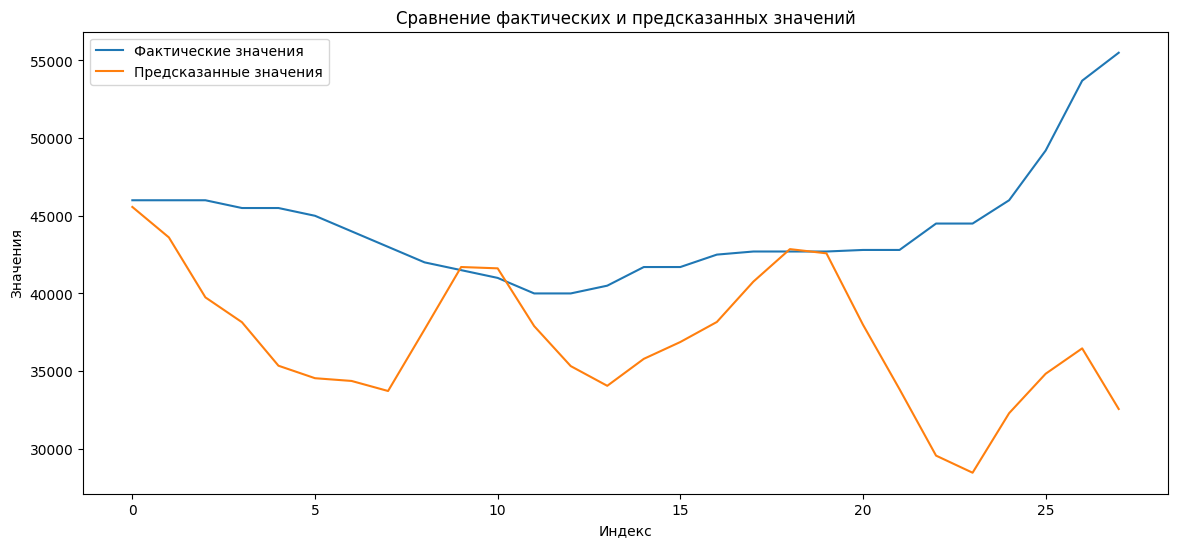

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(df_test.reset_index(drop=True), label='Фактические значения')
plt.plot(y, label='Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Индекс')
plt.ylabel('Значения')
plt.legend()
plt.show()